In [1]:
import os
import sqlite3
import datetime
import socket
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.path as mplPath
from rubin_sim.utils import (
    _hpid2_ra_dec,
    xyz_angular_radius,
    _build_tree,
    _xyz_from_ra_dec, healbin
)
from rubin_sim.scheduler.utils import hp_kd_tree, SchemaConverter, HpInLsstFov
from rubin_sim.scheduler.features import BaseSurveyFeature
from scipy.stats import binned_statistic
from rubin_sim.data import get_baseline

import numpy.lib.recfunctions as rfn

import time

In [2]:
class NObservations(BaseSurveyFeature):
    """
    Track the number of observations that have been made across the sky.

    Parameters
    ----------
    filtername : str ('r')
        String or list that has all the filters that can count.
    nside : int (32)
        The nside of the healpixel map to use
    """

    def __init__(self, filtername=None, nside=None, survey_name=None):
        if nside is None:
            nside = utils.set_default_nside()

        self.bins = np.arange(hp.nside2npix(nside)+1) - 0.5
        
        self.feature = np.zeros(hp.nside2npix(nside), dtype=float)
        self.filtername = filtername
        self.survey_name = survey_name
        
    def add_observations_array(self, observations, observations_hpid):
        
        valid_indx = np.ones(observations_hpid.size, dtype=bool)
        if self.filtername is not None:
            valid_indx[np.where(observations_hpid['filter'] != self.filtername)[0]] = False
        if self.survey_name is not None:
            tmp = [name in self.survey_name for name in observations_hpid['note']]
            valid_indx = valid_indx * np.array(tmp)
        data = observations_hpid[valid_indx]
        result, _be, _bn = binned_statistic(data['hpid'], np.ones(data.size), statistic='sum', bins=self.bins)
        self.feature += result
        

    def add_observation(self, observation, indx=None):
        """
        Parameters
        ----------
        indx : ints
            The indices of the healpixel map that have been observed by observation
        """
        if self.filtername is None or observation["filter"][0] in self.filtername:
            if self.survey_name is None or observation["note"] in self.survey_name:
                self.feature[indx] += 1


In [3]:
baseline_db = get_baseline()
sc = SchemaConverter()

obs = sc.opsim2obs(baseline_db)

In [4]:
nside = 32
pointing2hpindx = HpInLsstFov(nside=nside)

In [5]:
# list-of-list for hpids
t1 = time.time()

lol_hpids = pointing2hpindx(obs['RA'], obs['dec'])



t2 = time.time()
dt = (t2-t1)
print('dt = %f ' % dt)

dt = 2.599315 


In [6]:
lol_hpids

array([list([7722, 7850, 7978]), list([7465, 7593, 7594, 7721]),
       list([7849, 7977]), ..., list([8132, 8261]), list([7875, 8004]),
       list([8260, 8387])], dtype=object)

In [7]:
# unravel the list of lists.
hpids = []
big_array_indx = []
for i,indxs in enumerate(lol_hpids):
    for indx in indxs:
        hpids.append(indx)
        big_array_indx.append(i)

In [8]:
hpids = np.array(hpids, dtype=[("hpid", int)])

In [9]:
# Look for a faster way to do this one. 
#obs_array_hpid = rfn.merge_arrays((obs[big_array_indx], hpids))

names = list(obs.dtype.names)
types = [obs[name].dtype for name in names]

names.append(hpids.dtype.names[0])
types.append(hpids['hpid'].dtype)
ndt = list(zip(names, types))

obs_array_hpid = np.empty(
        hpids.size, 
        dtype=ndt)
obs_array_hpid[list(obs.dtype.names)] = obs[big_array_indx]
obs_array_hpid[hpids.dtype.names[0]] = hpids


In [10]:
# Let's make 2 features
nside=32
f1 = NObservations(filtername="r", nside=nside)
f2 = NObservations(filtername="r", nside=nside)

In [11]:
t1 = time.time()
f1.add_observations_array(obs, obs_array_hpid )
t2 = time.time()
dt = (t2-t1)
print('dt = %f ' % dt)

dt = 0.547592 


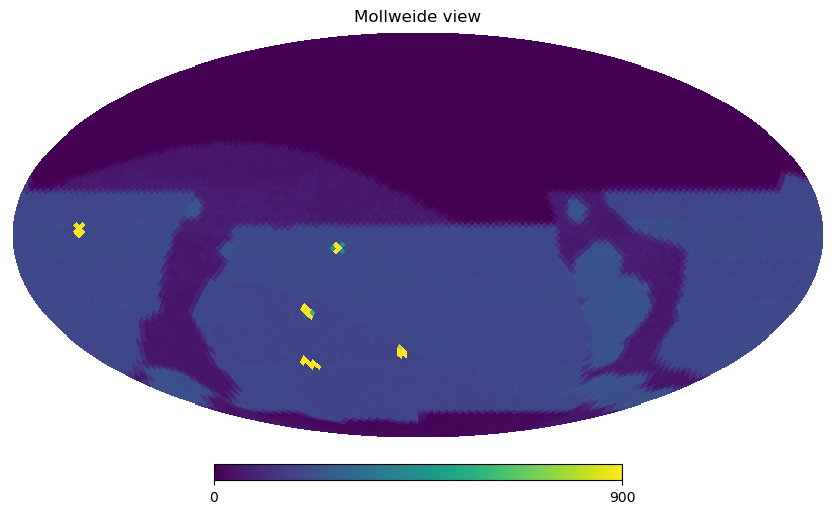

In [12]:
hp.mollview(f1.feature, max=900)

In [13]:
t1 = time.time()
for ob in obs:
    indx = pointing2hpindx(ob['RA'], ob['dec'])
    f2.add_observation(ob, indx=indx)
    
t2 = time.time()
dt = (t2-t1)
print('dt = %f ' % dt)

dt = 43.551598 


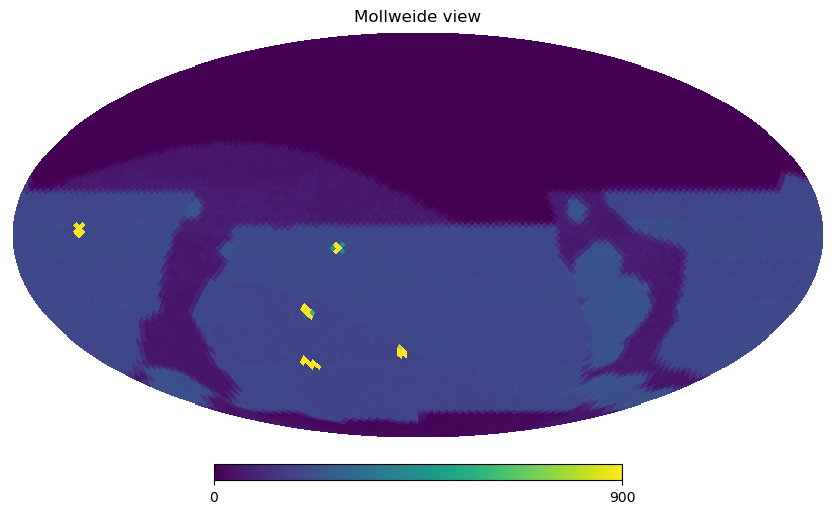

In [14]:
hp.mollview(f2.feature, max=900)

In [15]:
False in (f2.feature == f1.feature)

False

In [16]:
# try it again with no filter 
f1 = NObservations(filtername=None, nside=nside)
f2 = NObservations(filtername=None, nside=nside)

dt = 1.813488 


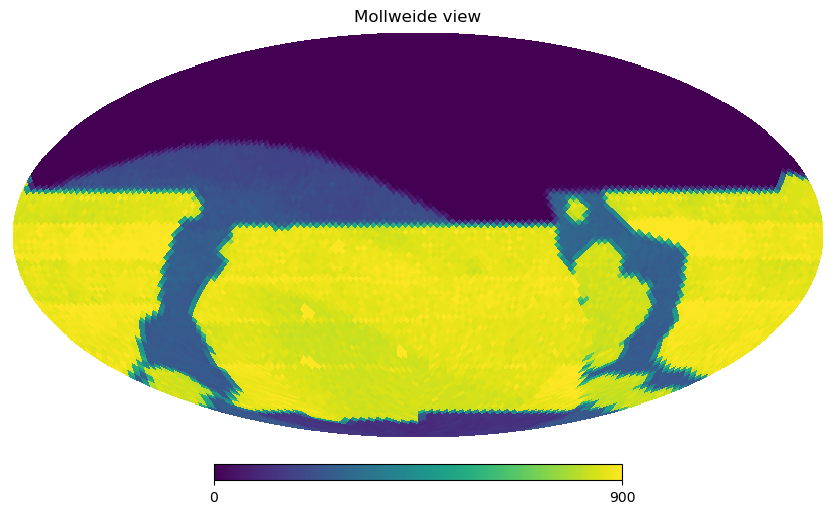

In [17]:
t1 = time.time()
f1.add_observations_array(obs, obs_array_hpid )
t2 = time.time()
dt = (t2-t1)
print('dt = %f ' % dt)

hp.mollview(f1.feature, max=900)

dt = 45.254712 


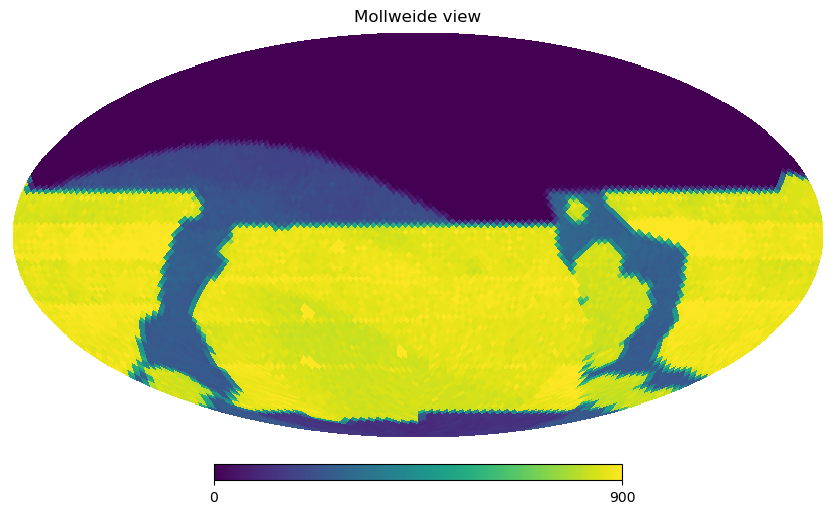

In [18]:
t1 = time.time()
for ob in obs:
    indx = pointing2hpindx(ob['RA'], ob['dec'])
    f2.add_observation(ob, indx=indx)
    
t2 = time.time()
dt = (t2-t1)
print('dt = %f ' % dt)
hp.mollview(f2.feature, max=900)

In [19]:
False in (f2.feature == f1.feature)

False